In [1]:
!pip install https://github.com/CenterForTheBuiltEnvironment/pythermalcomfort/archive/master.zip

     - 215kB 5.4MB/s
  Created wheel for pythermalcomfort: filename=pythermalcomfort-1.0.2-py2.py3-none-any.whl size=27449 sha256=b7dda9c49316445f8c90937d3265b3b18b8dd8b6c94d59e3f6d4a2cb141bc0da
  Stored in directory: /tmp/pip-ephem-wheel-cache-1v2e4547/wheels/3e/c0/a8/44298b11f53ceaf25bb41af85b0b984e203aa79a10410566c9
Successfully built pythermalcomfort
You should consider upgrading via the 'pip install --upgrade pip' command.


In [127]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D, Flatten, MaxPooling1D
import tensorflow as tf
import numpy as np
from numpy import genfromtxt
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from pythermalcomfort.models import pmv
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
warnings.simplefilter("ignore")

In [3]:
val = [-1, 0, 1]
#Funkcja przetwarzająca ocenę klas na konkretną etykietę
def createLabel(y_score):
    _y_pred = [];
    for pred in y_score:
        _y_pred.append(val[np.argmax(pred)])
    return _y_pred;

#Funckja wyświetlająca macierz pomyłek
def confMatrix(y_test_class, y_pred):
    _cm = confusion_matrix(y_test_class, y_pred)

    _cm_sum = np.sum(_cm, axis=1, keepdims=True)
    _cm_perc = _cm / _cm_sum.astype(float) * 100

    plt.imshow(_cm_perc, cmap=plt.cm.Blues)
    plt.xlabel("Wartości przewidywane")
    plt.ylabel("Wartości rzeczywiste")
    plt.xticks([0,1,2], [-1,0,1])
    plt.yticks([0,1,2], [-1,0,1])
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top') 

    for y in range(3):
        for x in range(3):
            plt.text(x, y, '%d ' % _cm[y, x],
                    horizontalalignment='center',
                    verticalalignment='center', color=('White' if _cm_perc[y,x] > 50 else 'Black'))


    plt.title('Macierz pomyłek')
    plt.colorbar()
    plt.show()

In [134]:
#funkcja oceniająca model pod kątem wskaźnika PMV
def PMVEvaluate(model, x_test_v, tempIx = 2, vrIx = 4, rhIx = 3):
    i = 0
    i2 = 0
    pos_sum = 0
    err_sum = 0
    pmv_data_c = []
    val = [-1, 0, 1]
    poly = PolynomialFeatures(interaction_only=True)
    scaler = StandardScaler()
    for item in x_test_v:
        #transformacja pojedynczych próbki do odpowiedniego wymiaru
        t_item = np.reshape(item, (1, item.shape[0]))
        scaler.fit(t_item)
        t_item = poly.fit_transform(t_item)
        
        #wyznaczenie predykcji poszczególnych klas
        pred = model.predict(np.reshape(t_item, (1,t_item.shape[1], 1)));
        #przetworzenie prawdopodobieńst na klasę, oraz przekształcenie jej na zmianę temperatury
        pred_D_temp_c = val[np.argmax(pred)] * 0.25
        #wyciągnięcie poprzedniej wartości PMV
        prevPMV = item[9]
        
        #wyliczenie nowej wartości PMV na podstawie poprzednich wartości 
        newPMV = pmv(tdb=item[tempIx]+pred_D_temp_c, tr=item[tempIx]+pred_D_temp_c, vr=item[vrIx], rh=item[rhIx], met=1, clo=0.5)
        
        pmv_data_c.append((prevPMV, newPMV, abs(prevPMV) - abs(newPMV),));
        if( abs(prevPMV) - abs(newPMV) < 0):
            i+=1
            err_sum -= abs(newPMV) - abs(prevPMV)
        else:
            i2+=1
            pos_sum -= abs(newPMV) - abs(prevPMV) 
    print(i, (x_test.shape[0] - i) / x_test.shape[0])
    print(pos_sum/i2)
    print(err_sum/i)
    return 

In [114]:
def getData(name):
    data = pd.read_csv(name, sep=';') 
    data = data.drop("Data pomiaru", axis=1)
    target = np.sign(data["3-INDOOR Ambient Temp. Δ +1"]);
    data.drop("3-INDOOR Ambient Temp. Δ +1", axis=1)

    np_data = np.array(data)
    np_target = np.array(target)
    mask = np_data[:, 20] > 0
    np_target[mask] = np_target[mask]  * -1

    mask1 = (np_target == 0) & (np_data[:, 20] > 0) & (np_data[:, 9] < 0)
    mask2 = (np_target == 0) & (np_data[:, 20] > 0) & (np_data[:, 9] > 0)
    np_target[mask1] = 1
    np_target[mask2] = -1

    data = np_data
    target = np_target

    poly = PolynomialFeatures(degree = 2, interaction_only=True)
    scaler = StandardScaler()

    scaler.fit(data)
    data = poly.fit_transform(data)

    return train_test_split(data, target, np_data, test_size=0.2)

In [115]:
def prepareClassTarget(train, test):
    train_class = train
    test_class = test

    train_c = train + 1
    test_c = test + 1
    train_c = np.eye(3)[np.array(train_c, dtype=int)]
    test_c = np.eye(3)[np.array(test_c, dtype=int)]
    return (train_c, train_class, test_c, test_class)

def prepare3dData(train, test):
    train_3 = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test_3 = np.reshape(test, (test.shape[0], test.shape[1], 1))
    return (train_3, test_3)

In [116]:
x_train, x_test, y_train, y_test, x_train_v, x_test_v = getData("DS-Z7.csv")

In [117]:
y_train, y_train_class, y_test, y_test_class = prepareClassTarget(y_train, y_test)

In [118]:
x_train_3, x_test_3 = prepare3dData(x_train, x_test)

In [119]:
x_train_3.shape

(19796, 254, 1)

In [123]:
X = x_train_3
Y = y_train
model_c = Sequential([
    Conv1D(filters=64, kernel_size=3 ,strides=1,     
                  batch_input_shape=(None, X.shape[1], 1),kernel_initializer= 'uniform',      
                  activation= 'relu'),
    Conv1D(filters=64, kernel_size=3 ,strides=1),
    MaxPooling1D(),
    Conv1D(filters=32, kernel_size=3 ,strides=1),
    Conv1D(filters=32, kernel_size=3 ,strides=1),
    MaxPooling1D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

model_c.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_c = model_c.fit(X, Y, epochs=5, validation_split=0.1)

Train on 17816 samples, validate on 1980 samples
Epoch 1/5
17816/17816 [==============================] - 111s 6ms/step - loss: 0.9759 - accuracy: 0.5919 - val_loss: 0.7608 - val_accuracy: 0.6803
Epoch 2/5
17816/17816 [==============================] - 109s 6ms/step - loss: 0.5118 - accuracy: 0.8003 - val_loss: 0.4174 - val_accuracy: 0.8394
Epoch 3/5
17816/17816 [==============================] - 108s 6ms/step - loss: 0.2467 - accuracy: 0.9104 - val_loss: 0.1449 - val_accuracy: 0.9475
Epoch 4/5
17816/17816 [==============================] - 118s 7ms/step - loss: 0.1160 - accuracy: 0.9608 - val_loss: 0.0752 - val_accuracy: 0.9788
Epoch 5/5
17816/17816 [==============================] - 111s 6ms/step - loss: 0.0707 - accuracy: 0.9768 - val_loss: 0.0424 - val_accuracy: 0.9869


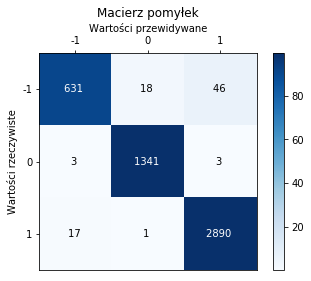

In [131]:
y_pred = createLabel(model_c.predict(x_test_3))
confMatrix(y_test_class, y_pred)

In [135]:
PMVEvaluate(model_c, x_test_v)

1101 0.7775757575757576
0.07461701582229124
-0.054727234046321585


In [133]:
print("Ogólna precyzja klasyfikacji:", accuracy_score(y_test_class, y_pred))
print("Średnia precyzja klasyfikacji:",balanced_accuracy_score(y_test_class, y_pred))

Ogólna precyzja klasyfikacji: 0.9822222222222222
Średnia precyzja klasyfikacji: 0.9657565016324648


# TESTY

In [30]:
data = pd.read_csv("DS-Z7.csv", sep=';') 
data = data.drop("Data pomiaru", axis=1)
train, test = train_test_split(data, test_size=0.2)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data)

y_train =  np.array(train["3-INDOOR Ambient Temp. Δ +1"])
x_train = np.array(train.drop("3-INDOOR Ambient Temp. Δ +1", axis=1))
y_test = np.array(test["3-INDOOR Ambient Temp. Δ +1"])
x_test = np.array(test.drop("3-INDOOR Ambient Temp. Δ +1", axis=1))

In [46]:
train_c, test_c = train_test_split(data, test_size=0.2)

y_train_c =  np.sign(np.array(train_c["3-INDOOR Ambient Temp. Δ +1"]))
x_train_c = np.array(train_c.drop("3-INDOOR Ambient Temp. Δ +1", axis=1))
y_test_c = np.sign(np.array(test_c["3-INDOOR Ambient Temp. Δ +1"]))
x_test_c = np.array(test_c.drop("3-INDOOR Ambient Temp. Δ +1", axis=1))

In [47]:
y_train_class = y_train_c
y_test_class = y_test_c

In [48]:
y_train_c = y_train_c + 1
y_test_c = y_test_c + 1

In [50]:
sum(y_train_c)

18586.0

In [9]:
x_train_c.shape

(19796, 21)

In [51]:
y_train_c = np.eye(3)[np.array(y_train_c, dtype=int)]
y_test_c = np.eye(3)[np.array(y_test_c, dtype=int)]

In [58]:
x_train_c1 = np.reshape(x_train_c, (x_train_c.shape[0], x_train_c.shape[1], 1))
x_test_c1 = np.reshape(x_test_c, (x_test_c.shape[0], x_test_c.shape[1], 1))

In [61]:
model_c1 = Sequential([
    Conv1D(filters=5, kernel_size=3 ,strides=1,     
                  batch_input_shape=(None, 21, 1),kernel_initializer= 'uniform',      
                  activation= 'relu'),
    Conv1D(filters=3, kernel_size=3 ,strides=1),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

model_c1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_c1 = model_c1.fit(x_train_c1, y_train_c, epochs=40, validation_split=0.1)

Train on 17816 samples, validate on 1980 samples
Epoch 1/40
17816/17816 [==============================] - 10s 574us/step - loss: 0.9460 - accuracy: 0.5350 - val_loss: 0.8655 - val_accuracy: 0.6293
Epoch 2/40
17816/17816 [==============================] - 5s 294us/step - loss: 0.8482 - accuracy: 0.6170 - val_loss: 0.8276 - val_accuracy: 0.6288
Epoch 3/40
17816/17816 [==============================] - 5s 304us/step - loss: 0.8191 - accuracy: 0.6269 - val_loss: 0.8291 - val_accuracy: 0.6328
Epoch 4/40
17816/17816 [==============================] - 6s 313us/step - loss: 0.8032 - accuracy: 0.6344 - val_loss: 0.7924 - val_accuracy: 0.6379
Epoch 5/40
17816/17816 [==============================] - 6s 316us/step - loss: 0.7912 - accuracy: 0.6375 - val_loss: 0.7884 - val_accuracy: 0.6399
Epoch 6/40
17816/17816 [==============================] - 5s 297us/step - loss: 0.7810 - accuracy: 0.6424 - val_loss: 0.7812 - val_accuracy: 0.6510
Epoch 7/40
17816/17816 [==============================] - 6s 3

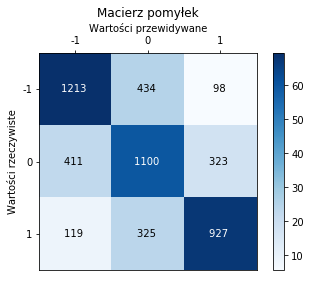

In [63]:
y_pred = createLabel(model_c1.predict(x_test_c1))
confMatrix(y_test_class, y_pred)

In [223]:
from sklearn.preprocessing import PolynomialFeatures

data = pd.read_csv("DS-Z7.csv", sep=';') 
data = data.drop("Data pomiaru", axis=1)
target = np.sign(data["3-INDOOR Ambient Temp. Δ +1"]);
data.drop("3-INDOOR Ambient Temp. Δ +1", axis=1)

np_data = np.array(data)
np_target = np.array(target)
mask = np_data[:, 20] > 0
np_target[mask] = np_target[mask]  * -1

mask1 = (np_target == 0) & (np_data[:, 20] > 0) & (np_data[:, 9] < -0.9)
mask2 = (np_target == 0) & (np_data[:, 20] > 0) & (np_data[:, 9] > 0)
np_target[mask1] = 1
np_target[mask2] = -1

data = np_data
target = np_target
# data = pd.read_csv("DS-Z7.csv", sep=';') 
# data = data.drop("Data pomiaru", axis=1)
# target = np.sign(data["3-INDOOR Ambient Temp. Δ +1"]);
# data.drop("3-INDOOR Ambient Temp. Δ +1", axis=1)



from sklearn.preprocessing import StandardScaler

poly = PolynomialFeatures(interaction_only=True)
scaler = StandardScaler()

scaler.fit(data)
data = poly.fit_transform(data)

x_train_c2, x_test_c2, y_train_c2, y_test_c2, x_train_v, x_test_v = train_test_split(data, target, np_data, test_size=0.2)

In [226]:
y_train_c2_class = y_train_c2
y_test_c2_class = y_test_c2

y_train_c2 = y_train_c2 + 1
y_test_c2 = y_test_c2 + 1
y_train_c2 = np.eye(3)[np.array(y_train_c2, dtype=int)]
y_test_c2 = np.eye(3)[np.array(y_test_c2, dtype=int)]

In [228]:
x_train_c2_3 = np.reshape(x_train_c2, (x_train_c2.shape[0], x_train_c2.shape[1], 1))
x_test_c2_3 = np.reshape(x_test_c2, (x_test_c2.shape[0], x_test_c2.shape[1], 1))

In [238]:
model_c2 = Sequential([
#     Conv1D(filters=64, kernel_size=3 ,strides=1,     
#                   batch_input_shape=(None, 254, 1),kernel_initializer= 'uniform',      
#                   activation= 'relu'),
#     Conv1D(filters=32, kernel_size=3 ,strides=1),
#     Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

model_c2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_c2 = model_c2.fit(x_train_c2, y_train_c2, epochs=30, validation_split=0.1)

Train on 17816 samples, validate on 1980 samples
Epoch 1/30
17816/17816 [==============================] - 4s 238us/step - loss: 6.8278 - accuracy: 0.4881 - val_loss: 0.9636 - val_accuracy: 0.5758
Epoch 2/30
17816/17816 [==============================] - 3s 195us/step - loss: 1.0098 - accuracy: 0.5650 - val_loss: 0.9083 - val_accuracy: 0.5889
Epoch 3/30
17816/17816 [==============================] - 3s 196us/step - loss: 0.9308 - accuracy: 0.5860 - val_loss: 0.9231 - val_accuracy: 0.5798
Epoch 4/30
17816/17816 [==============================] - 3s 178us/step - loss: 0.8888 - accuracy: 0.5955 - val_loss: 0.8227 - val_accuracy: 0.5990
Epoch 5/30
17816/17816 [==============================] - 3s 192us/step - loss: 0.8331 - accuracy: 0.6197 - val_loss: 0.8341 - val_accuracy: 0.6237
Epoch 6/30
17816/17816 [==============================] - 4s 220us/step - loss: 0.7984 - accuracy: 0.6308 - val_loss: 0.6742 - val_accuracy: 0.7217
Epoch 7/30
17816/17816 [==============================] - 4s 21

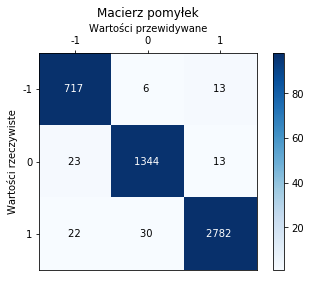

In [239]:
y_pred = createLabel(model_c2.predict(x_test_c2))
confMatrix(y_test_c2_class, y_pred)

In [240]:
i = 0
i2 = 0
sum = 0
err_sum = 0
pmv_data_c = []
val = [-1, 0, 1]
for item in x_test_v:
    t_item = np.reshape(item, (1, item.shape[0]))
    scaler.fit(t_item)
    t_item = poly.fit_transform(t_item)
    pred = model_c2.predict(np.reshape(t_item, (1,t_item.shape[1])));
    pred_D_temp_c = val[np.argmax(pred)] * 0.25
    prevPMV = item[9]
    newPMV = pmv(tdb=item[2]+pred_D_temp_c, tr=item[2]+pred_D_temp_c, vr=item[4], rh=item[3], met=1, clo=0.5)
    pmv_data_c.append((prevPMV, newPMV, abs(prevPMV) - abs(newPMV),));
    if( abs(prevPMV) - abs(newPMV) < 0):
        i+=1
        err_sum += abs(prevPMV) - abs(newPMV)
    else:
        i2+=1
        sum += abs(newPMV) - abs(prevPMV) 
print(i, (x_test.shape[0] - i) / x_test.shape[0])
print(sum/i2)
print(err_sum/i)

1187 0.7602020202020202
-0.07321415730002613
-0.058598797320977364
